In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose  # Add this import statement
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print('Libraries loaded')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Libraries loaded


In [2]:
# Read gym visitation data
milton_df = pd.read_csv("data/raw/milton.csv")
woodstock_df = pd.read_csv("data/raw/woodstock.csv")
roswell_df = pd.read_csv("data/raw/roswell.csv")
roswell_problem_df = pd.read_csv("data/raw/roswell_problem.csv")

In [12]:
# Function to calculate visitor count
def calculate_visitor_count(df):
    # Convert visit_start_time and visit_end_time to datetime objects
    df['visit_start_time'] = pd.to_datetime(df['visit_start_time'])
    df['visit_end_time'] = pd.to_datetime(df['visit_end_time'])
    
    # Calculate number of days for each visit
    df['visit_duration'] = (df['visit_end_time'] - df['visit_start_time']).dt.days + 1
    # Calculate visitor count
    df['visitor_count'] = df['visit_weight'] * df['visit_duration']
    return df

# Apply calculate_visitor_count function to each DataFrame
milton_df = calculate_visitor_count(milton_df)
woodstock_df = calculate_visitor_count(woodstock_df)
roswell_problem_df = calculate_visitor_count(roswell_problem_df)
roswell_df = calculate_visitor_count(roswell_df)

# Define the function to generate daily visit counts
def daily_visit_counts(df):
    df["visit_start_time"] = pd.to_datetime(df["visit_start_time"])
    df = df.set_index("visit_start_time")
    daily_counts = df.resample("D")["visitor_count"].sum()
    return daily_counts

# Pre-process data
milton_counts = daily_visit_counts(milton_df.copy())
woodstock_counts = daily_visit_counts(woodstock_df.copy())
roswell_problem_counts = daily_visit_counts(roswell_problem_df.copy())
roswell_counts = daily_visit_counts(roswell_df.copy())

# Define sliding window size
window_size = 7  # You can adjust this as needed

# Function to create features (X) and target variable (y)
def create_X_y(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Create features and target variable for Woodstock gym
X_woodstock, y_woodstock = create_X_y(woodstock_counts, window_size)

# Split data into training and testing sets
X_train_woodstock, X_test_woodstock, y_train_woodstock, y_test_woodstock = train_test_split(X_woodstock, y_woodstock, test_size=0.2, random_state=42)

# Create features and target variable for Milton gym
X_milton, y_milton = create_X_y(milton_counts, window_size)

# Create features and target variable for Roswell gym
X_roswell, y_roswell = create_X_y(roswell_counts, window_size)

# Create features and target variable for Roswell Problem gym
X_roswell_problem, y_roswell_problem = create_X_y(roswell_problem_counts, window_size)

# Split data into training and testing sets for Milton gym
X_train_milton, X_test_milton, y_train_milton, y_test_milton = train_test_split(X_milton, y_milton, test_size=0.2, random_state=42)

# Split data into training and testing sets for Roswell gym
X_train_roswell, X_test_roswell, y_train_roswell, y_test_roswell = train_test_split(X_roswell, y_roswell, test_size=0.2, random_state=42)

# Split data into training and testing sets for Roswell Problem gym
X_train_roswell_problem, X_test_roswell_problem, y_train_roswell_problem, y_test_roswell_problem = train_test_split(X_roswell_problem, y_roswell_problem, test_size=0.2, random_state=42)


# Function to forecast using ARIMA model
def arima_forecast(data, train_size):
    decomposition = seasonal_decompose(data[:train_size])
    trend = decomposition.trend
    model = ARIMA(trend, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(data) - train_size)
    return forecast

# Function to forecast using Random Forest Regression model
def random_forest_forecast(data, train_size):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    scaled_train, scaled_test = scaled_data[:train_size], scaled_data[train_size:]
    model = RandomForestRegressor(n_estimators=100)
    model.fit(scaled_train, data[:train_size])
    forecast = model.predict(scaled_test.reshape(-1, 1))
    forecast = scaler.inverse_transform(forecast.reshape(-1, 1))
    return pd.Series(forecast.flatten(), index=data.index[train_size:])

# Define train_size
train_size = int(len(milton_counts) * 0.8)  # Use 80% for training, 20% for testing

# Forecast future visit counts using ARIMA model
milton_arima_forecast = arima_forecast(milton_counts, train_size)
woodstock_arima_forecast = arima_forecast(woodstock_counts, train_size)
roswell_problem_arima_forecast = arima_forecast(roswell_problem_counts, train_size)
roswell_arima_forecast = arima_forecast(roswell_counts, train_size)

# Forecast future visit counts using Random Forest Regression model
milton_rf_forecast = random_forest_forecast(milton_counts, train_size)
woodstock_rf_forecast = random_forest_forecast(woodstock_counts, train_size)
roswell_problem_rf_forecast = random_forest_forecast(roswell_problem_counts, train_size)
roswell_rf_forecast = random_forest_forecast(roswell_counts, train_size)

# Print or use the forecasts as needed


/var/folders/vx/n4xm54gd5g15czs1d5cvl6_m0000gn/T/ipykernel_12437/1530701435.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i+window_size])


In [13]:
# Split data into training and testing sets after handling missing values
X_train_woodstock, X_test_woodstock, y_train_woodstock, y_test_woodstock = train_test_split(X_woodstock, y_woodstock, test_size=0.2, random_state=42)
X_train_roswell, X_test_roswell, y_train_roswell, y_test_roswell = train_test_split(X_roswell, y_roswell, test_size=0.2, random_state=42)
X_train_roswell_problem, X_test_roswell_problem, y_train_roswell_problem, y_test_roswell_problem = train_test_split(X_roswell_problem, y_roswell_problem, test_size=0.2, random_state=42)

# Train linear regression model after handling missing values
model_lr_milton = LinearRegression()
model_lr_milton.fit(X_train_milton, y_train_milton)

model_lr_woodstock = LinearRegression()
model_lr_woodstock.fit(X_train_woodstock, y_train_woodstock)

model_lr_roswell = LinearRegression()
model_lr_roswell.fit(X_train_roswell, y_train_roswell)

model_lr_roswell_problem = LinearRegression()
model_lr_roswell_problem.fit(X_train_roswell_problem, y_train_roswell_problem)

# Train random forest model after handling missing values
model_rf_milton = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_milton.fit(X_train_milton, y_train_milton)

model_rf_woodstock = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_woodstock.fit(X_train_woodstock, y_train_woodstock)

model_rf_roswell = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_roswell.fit(X_train_roswell, y_train_roswell)

model_rf_roswell_problem = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_roswell_problem.fit(X_train_roswell_problem, y_train_roswell_problem)

# Train neural network model after handling missing values
model_nn_milton = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
model_nn_milton.fit(X_train_milton, y_train_milton)

model_nn_woodstock = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
model_nn_woodstock.fit(X_train_woodstock, y_train_woodstock)

model_nn_roswell = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
model_nn_roswell.fit(X_train_roswell, y_train_roswell)

model_nn_roswell_problem = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
model_nn_roswell_problem.fit(X_train_roswell_problem, y_train_roswell_problem)

# Make predictions on the testing set
y_pred_lr_milton = model_lr_milton.predict(X_test_milton)
y_pred_rf_milton = model_rf_milton.predict(X_test_milton)
y_pred_nn_milton = model_nn_milton.predict(X_test_milton)

y_pred_lr_woodstock = model_lr_woodstock.predict(X_test_woodstock)
y_pred_rf_woodstock = model_rf_woodstock.predict(X_test_woodstock)
y_pred_nn_woodstock = model_nn_woodstock.predict(X_test_woodstock)

y_pred_lr_roswell = model_lr_roswell.predict(X_test_roswell)
y_pred_rf_roswell = model_rf_roswell.predict(X_test_roswell)
y_pred_nn_roswell = model_nn_roswell.predict(X_test_roswell)

y_pred_lr_roswell_problem = model_lr_roswell_problem.predict(X_test_roswell_problem)
y_pred_rf_roswell_problem = model_rf_roswell_problem.predict(X_test_roswell_problem)
y_pred_nn_roswell_problem = model_nn_roswell_problem.predict(X_test_roswell_problem)

# Evaluate the models
mse_lr_milton = mean_squared_error(y_test_milton, y_pred_lr_milton)
mse_rf_milton = mean_squared_error(y_test_milton, y_pred_rf_milton)
mse_nn_milton = mean_squared_error(y_test_milton, y_pred_nn_milton)

mse_lr_woodstock = mean_squared_error(y_test_woodstock, y_pred_lr_woodstock)
mse_rf_woodstock = mean_squared_error(y_test_woodstock, y_pred_rf_woodstock)
mse_nn_woodstock = mean_squared_error(y_test_woodstock, y_pred_nn_woodstock)

mse_lr_roswell = mean_squared_error(y_test_roswell, y_pred_lr_roswell)
mse_rf_roswell = mean_squared_error(y_test_roswell, y_pred_rf_roswell)
mse_nn_roswell = mean_squared_error(y_test_roswell, y_pred_nn_roswell)

mse_lr_roswell_problem = mean_squared_error(y_test_roswell_problem, y_pred_lr_roswell_problem)
mse_rf_roswell_problem = mean_squared_error(y_test_roswell_problem, y_pred_rf_roswell_problem)
mse_nn_roswell_problem = mean_squared_error(y_test_roswell_problem, y_pred_nn_roswell_problem)

print("Mean Squared Error for Milton Gym:")
print("Linear Regression:", mse_lr_milton)
print("Random Forest:", mse_rf_milton)
print("Neural Network:", mse_nn_milton)
print()
print("Mean Squared Error for Woodstock Gym:")
print("Linear Regression:", mse_lr_woodstock)
print("Random Forest:", mse_rf_woodstock)
print("Neural Network:", mse_nn_woodstock)
print()
print("Mean Squared Error for Roswell Gym:")
print("Linear Regression:", mse_lr_roswell)
print("Random Forest:", mse_rf_roswell)
print("Neural Network:", mse_nn_roswell)
print()
print("Mean Squared Error for Underperforming Roswell Gym:")
print("Linear Regression:", mse_lr_roswell_problem)
print("Random Forest:", mse_rf_roswell_problem)
print("Neural Network:", mse_nn_roswell_problem)


Mean Squared Error for Milton Gym:
Linear Regression: 14580.078335626438
Random Forest: 15348.064332399019
Neural Network: 23766.875389902343

Mean Squared Error for Woodstock Gym:
Linear Regression: 51991.5000063987
Random Forest: 51145.387227245774
Neural Network: 56525.89733617644

Mean Squared Error for Roswell Gym:
Linear Regression: 39674.90209142589
Random Forest: 36798.61882941761
Neural Network: 43643.06257370266

Mean Squared Error for Underperforming Roswell Gym:
Linear Regression: 24191.67693519268
Random Forest: 20758.326716077823
Neural Network: 33002.041812305884


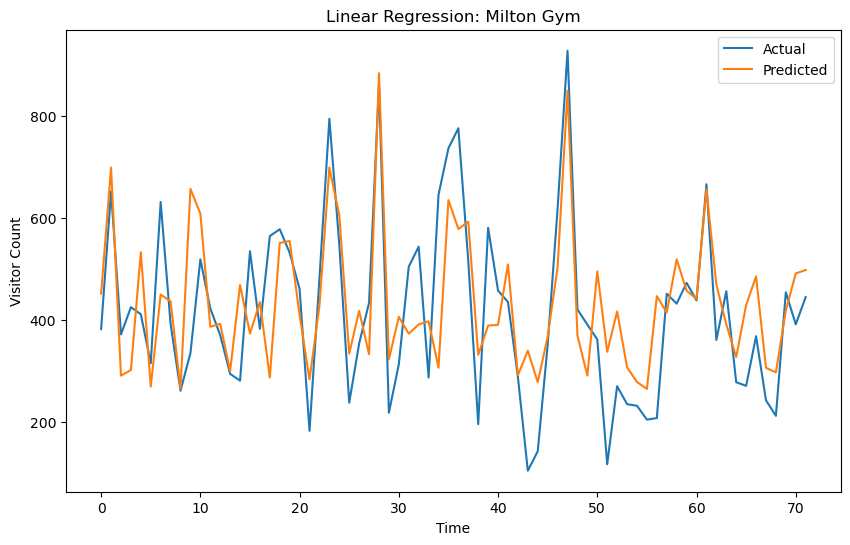

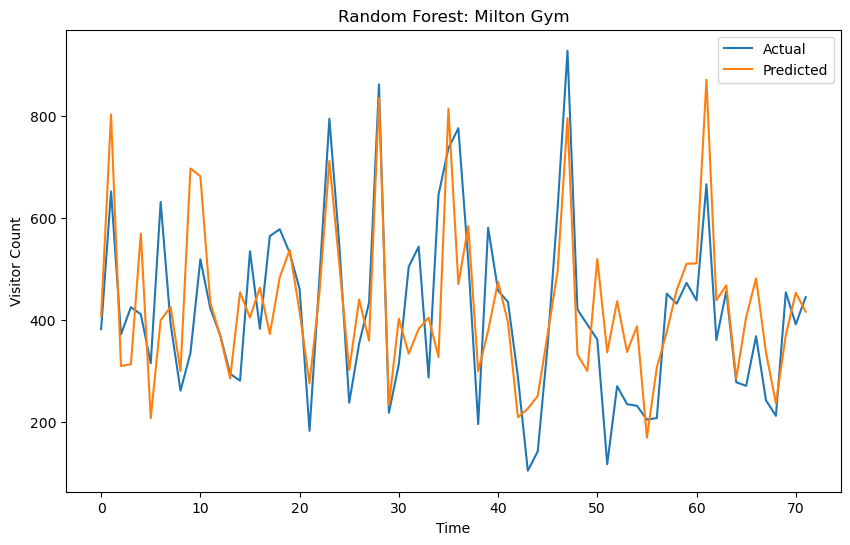

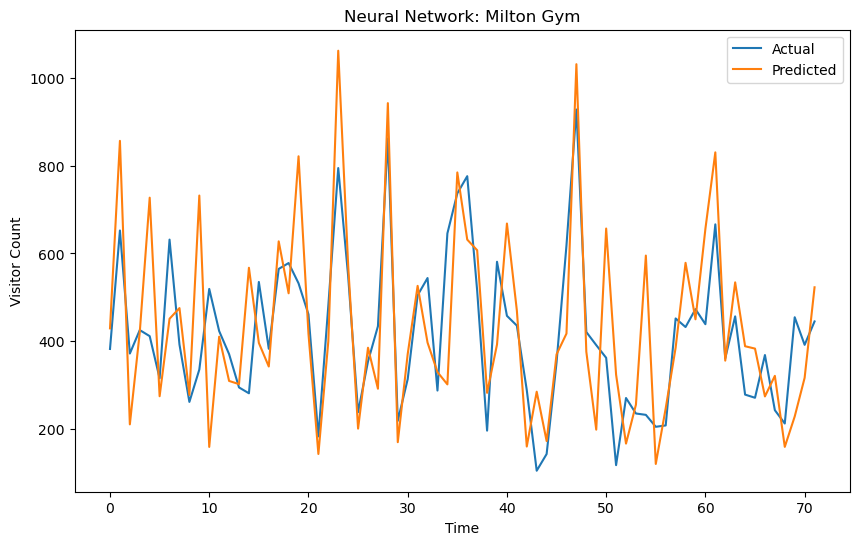

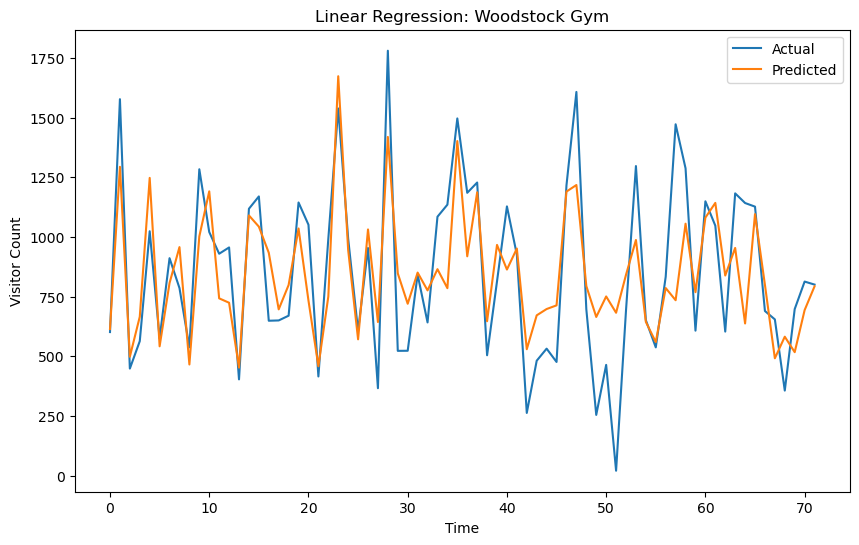

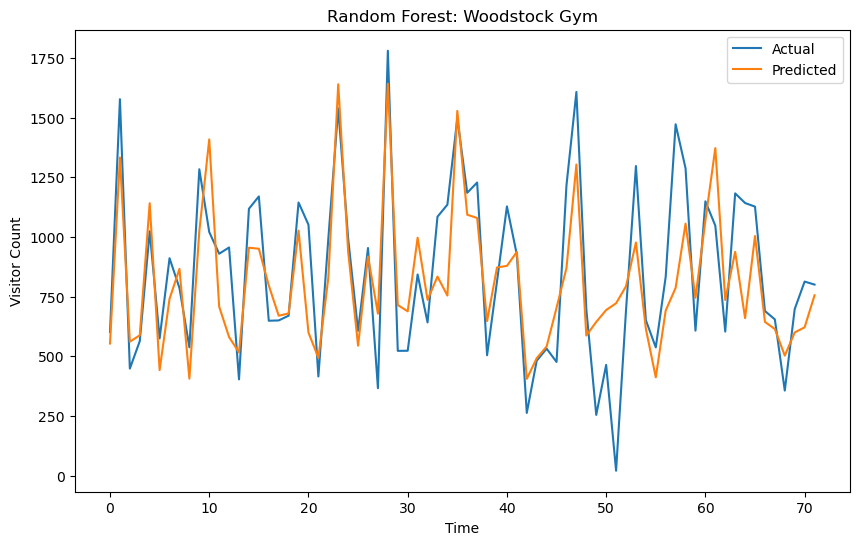

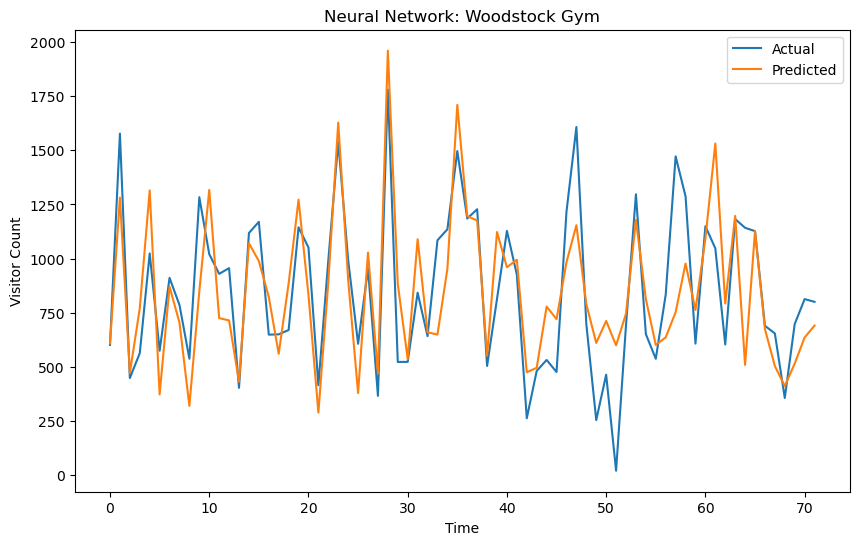

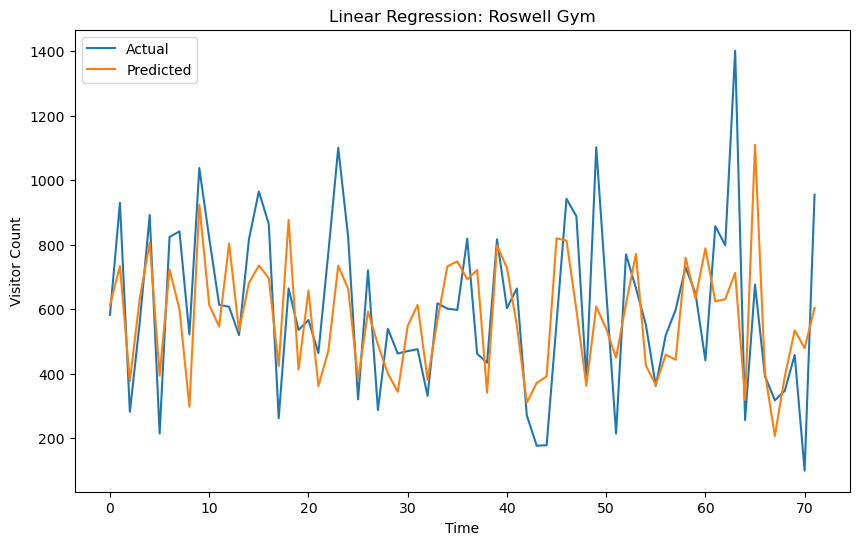

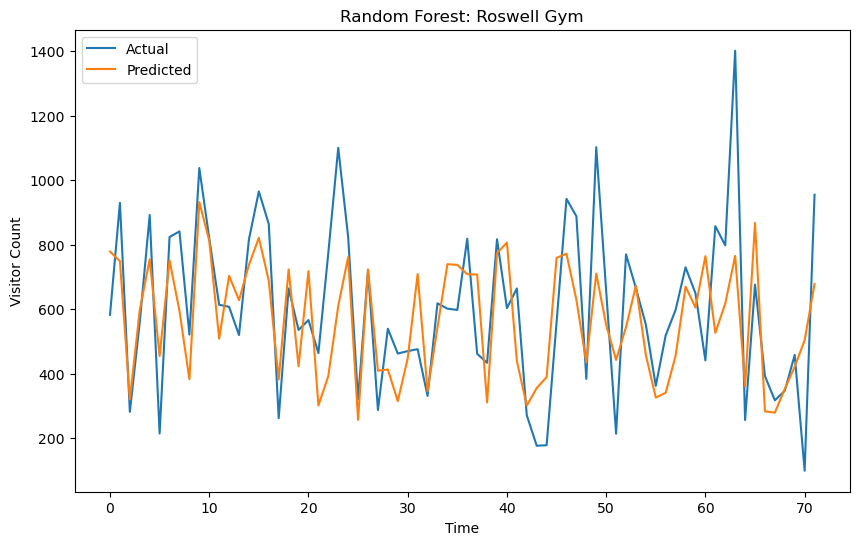

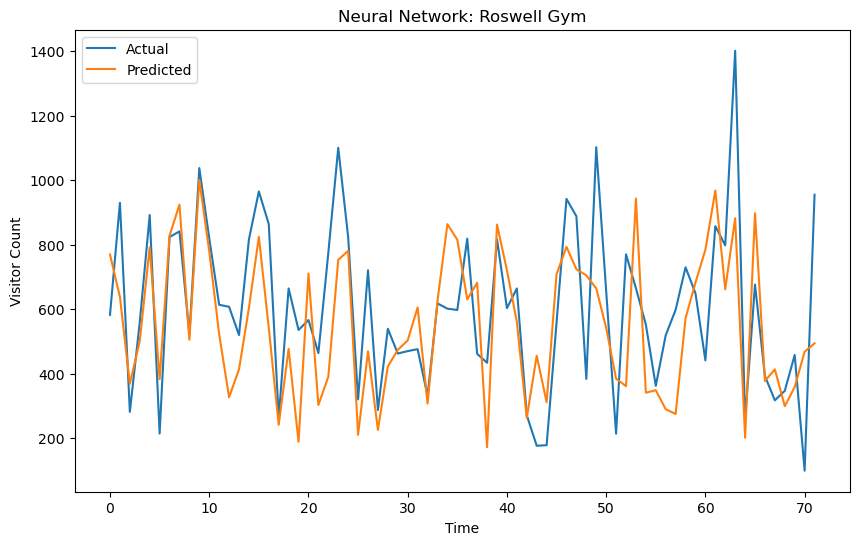

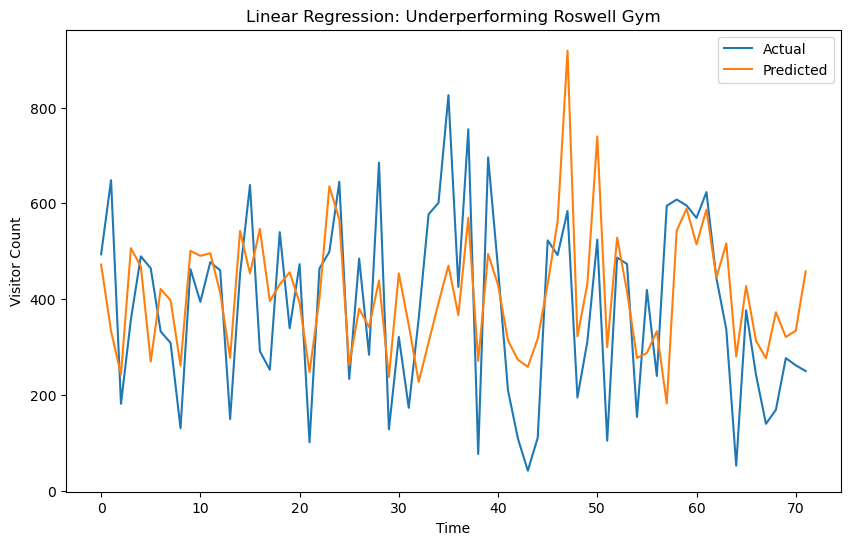

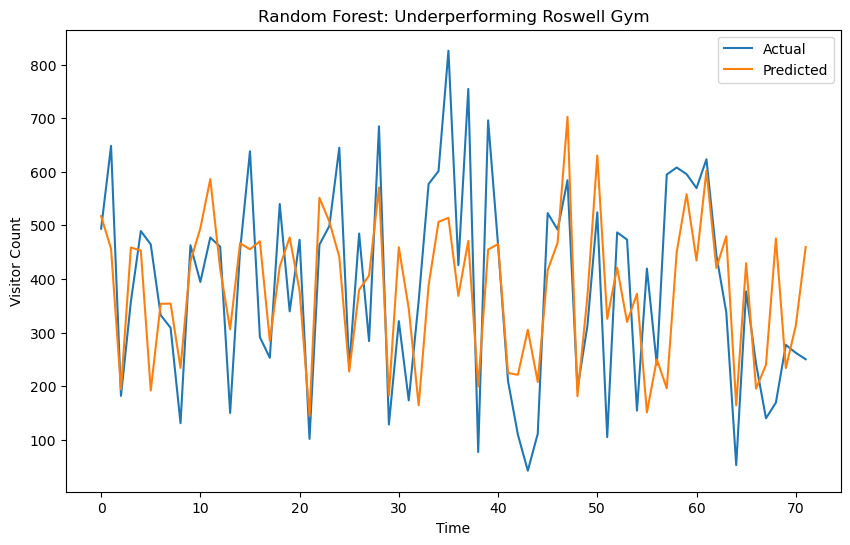

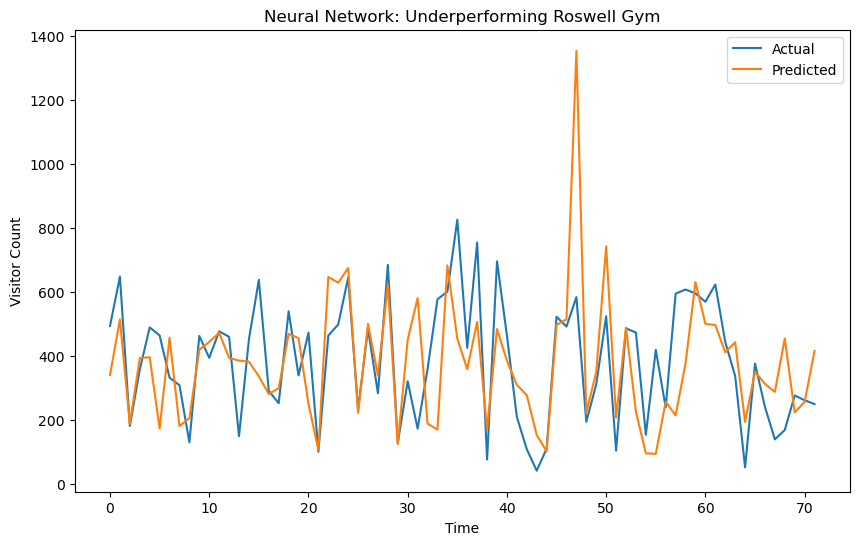

In [14]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(actual, predicted, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Visitor Count')
    plt.title(title)
    plt.legend()
    plt.show()

# Visualize predictions for Milton Gym
visualize_predictions(y_test_milton, y_pred_lr_milton, 'Linear Regression: Milton Gym')
visualize_predictions(y_test_milton, y_pred_rf_milton, 'Random Forest: Milton Gym')
visualize_predictions(y_test_milton, y_pred_nn_milton, 'Neural Network: Milton Gym')

# Visualize predictions for Woodstock Gym
visualize_predictions(y_test_woodstock, y_pred_lr_woodstock, 'Linear Regression: Woodstock Gym')
visualize_predictions(y_test_woodstock, y_pred_rf_woodstock, 'Random Forest: Woodstock Gym')
visualize_predictions(y_test_woodstock, y_pred_nn_woodstock, 'Neural Network: Woodstock Gym')

# Visualize predictions for Roswell Gym
visualize_predictions(y_test_roswell, y_pred_lr_roswell, 'Linear Regression: Roswell Gym')
visualize_predictions(y_test_roswell, y_pred_rf_roswell, 'Random Forest: Roswell Gym')
visualize_predictions(y_test_roswell, y_pred_nn_roswell, 'Neural Network: Roswell Gym')

# Visualize predictions for Underperforming Roswell Gym
visualize_predictions(y_test_roswell_problem, y_pred_lr_roswell_problem, 'Linear Regression: Underperforming Roswell Gym')
visualize_predictions(y_test_roswell_problem, y_pred_rf_roswell_problem, 'Random Forest: Underperforming Roswell Gym')
visualize_predictions(y_test_roswell_problem, y_pred_nn_roswell_problem, 'Neural Network: Underperforming Roswell Gym')


# Summary
## Milton Gym:
Linear Regression: MSE of 14580.08
Random Forest: MSE of 15348.06
Neural Network: MSE of 23766.88
These values indicate the average squared difference between the actual and predicted values for the Milton Gym. A lower MSE indicates better performance, so here, the Linear Regression model performs slightly better than the Random Forest model, while the Neural Network model has the highest MSE, indicating it might be the least accurate for this gym.

## Woodstock Gym:
Linear Regression: MSE of 51991.50
Random Forest: MSE of 51145.39
Neural Network: MSE of 56525.90
In this case, all three models seem to perform similarly, but none perform particularly well, as indicated by the high MSE values.

## Roswell Gym:
Linear Regression: MSE of 39674.90
Random Forest: MSE of 36798.62
Neural Network: MSE of 43643.06
The Random Forest model performs the best here, with the lowest MSE, followed by the Linear Regression model. The Neural Network model again has the highest MSE.

## Underperforming Roswell Gym:
Linear Regression: MSE of 24191.68
Random Forest: MSE of 20758.33
Neural Network: MSE of 33002.04

The Random Forest model stands out as the best performer for the underperforming Roswell Gym, with the lowest MSE. The Linear Regression model follows, while the Neural Network model has the highest MSE.

In summary, these MSE values provide insights into the relative performance of different machine learning models for forecasting gym visitors at different locations. Lower MSE values indicate better performance in predicting the number of visitors.




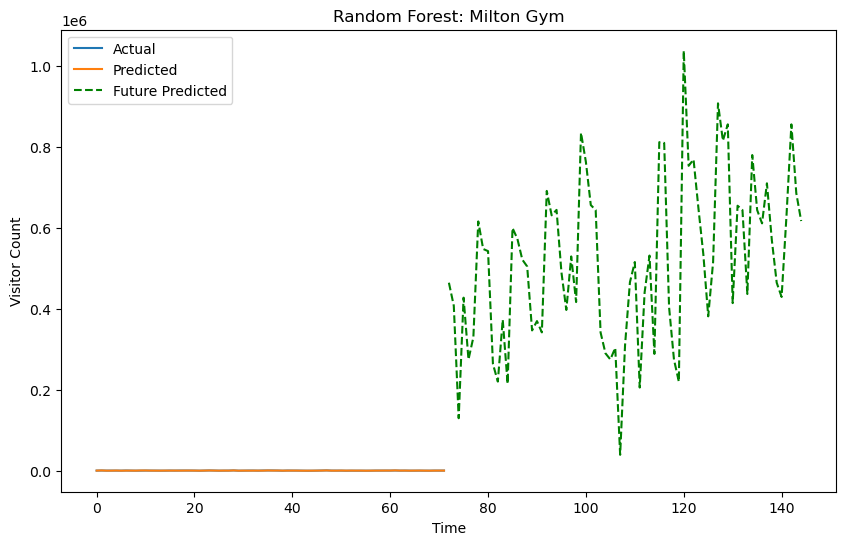

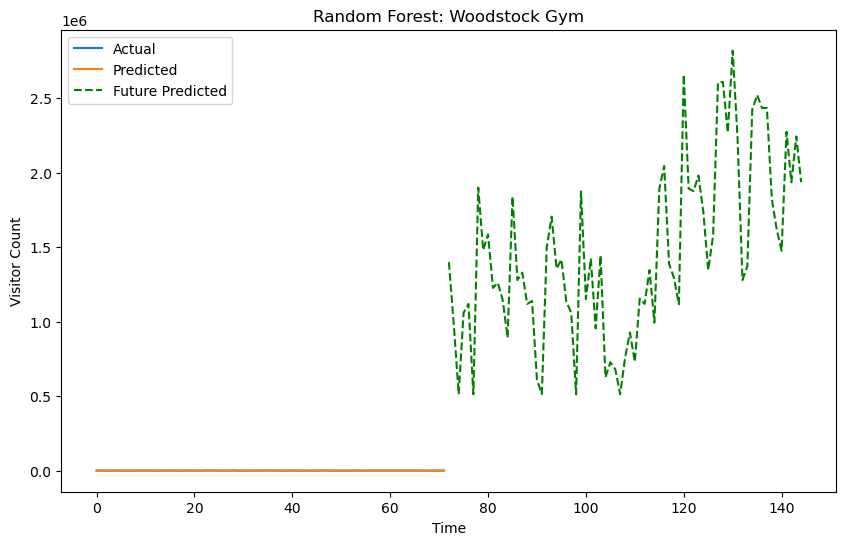

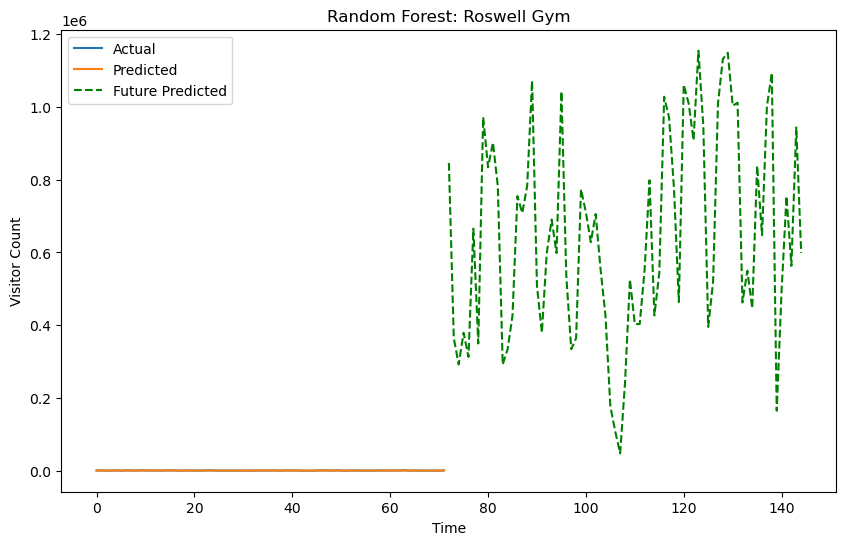

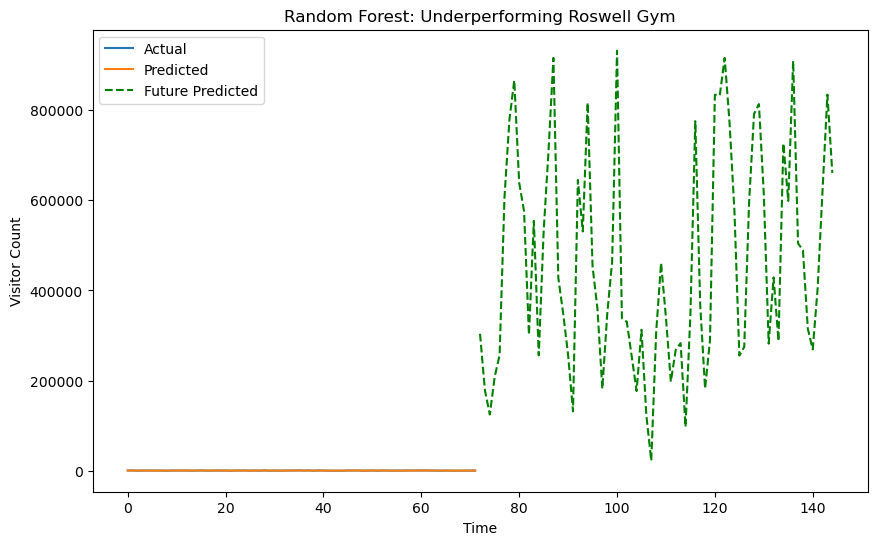

In [15]:
import numpy as np

# Define the number of future time steps to forecast
future_steps = 7  # Adjust as needed

# Function to visualize future predictions
def visualize_future_predictions(actual, predicted, future_predicted, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    future_index = np.arange(len(predicted), len(predicted) + len(future_predicted))
    plt.plot(future_index, future_predicted, label='Future Predicted', linestyle='--', color='green')
    plt.xlabel('Time')
    plt.ylabel('Visitor Count')
    plt.title(title)
    plt.legend()
    plt.show()

# Forecast future visit counts using Random Forest Regression model for Milton Gym
visualize_future_predictions(y_test_milton, y_pred_rf_milton, milton_rf_forecast, 'Random Forest: Milton Gym')

# Forecast future visit counts using Random Forest Regression model for Woodstock Gym
visualize_future_predictions(y_test_woodstock, y_pred_rf_woodstock, woodstock_rf_forecast, 'Random Forest: Woodstock Gym')

# Forecast future visit counts using Random Forest Regression model for Roswell Gym
visualize_future_predictions(y_test_roswell, y_pred_rf_roswell, roswell_rf_forecast, 'Random Forest: Roswell Gym')

# Forecast future visit counts using Random Forest Regression model for Underperforming Roswell Gym
visualize_future_predictions(y_test_roswell_problem, y_pred_rf_roswell_problem, roswell_problem_rf_forecast, 'Random Forest: Underperforming Roswell Gym')


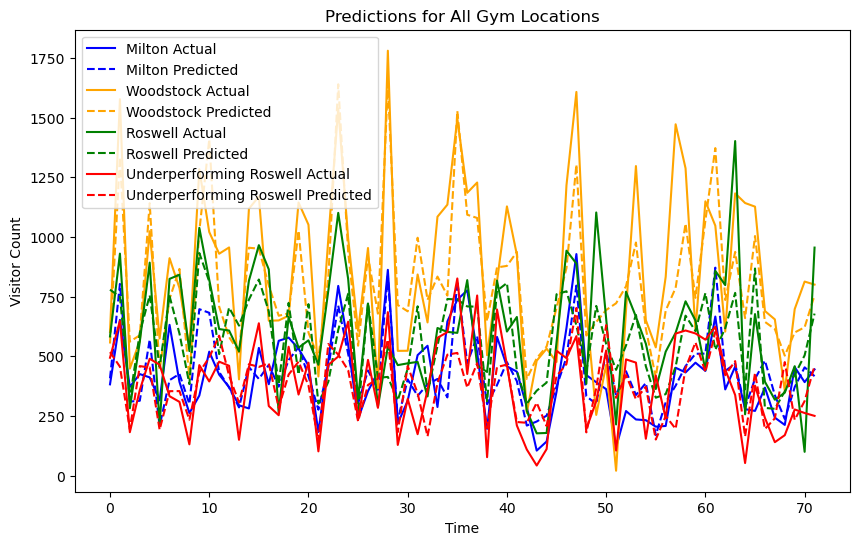

In [16]:
# Function to visualize predictions for all gym locations in one chart
def visualize_all_predictions(actuals, predictions, gym_labels):
    plt.figure(figsize=(10, 6))
    
    colors = ['blue', 'orange', 'green', 'red']
    for i, prediction in enumerate(predictions):
        plt.plot(actuals[i], label=gym_labels[i] + ' Actual', color=colors[i])
        plt.plot(prediction, label=gym_labels[i] + ' Predicted', linestyle='--', color=colors[i])

    plt.xlabel('Time')
    plt.ylabel('Visitor Count')
    plt.title('Predictions for All Gym Locations')
    plt.legend()
    plt.show()

# Define gym labels
gym_labels = ['Milton', 'Woodstock', 'Roswell', 'Underperforming Roswell']

# Gather actual and predicted values
actuals = [y_test_milton, y_test_woodstock, y_test_roswell, y_test_roswell_problem]
predictions = [y_pred_rf_milton, y_pred_rf_woodstock, y_pred_rf_roswell, y_pred_rf_roswell_problem]

# Visualize predictions for all gym locations
visualize_all_predictions(actuals, predictions, gym_labels)


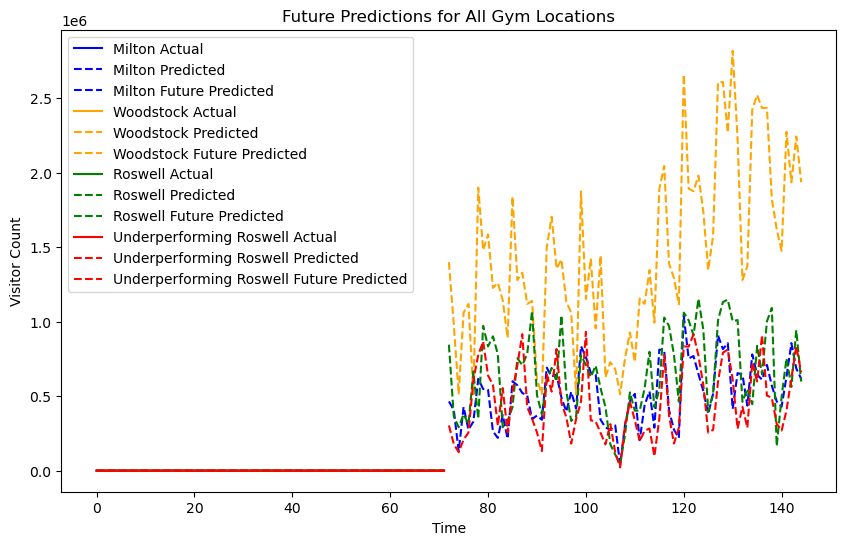

In [17]:
# Function to visualize future predictions for all gym locations
def visualize_all_future_predictions(actuals, predictions, future_predictions, gym_labels):
    plt.figure(figsize=(10, 6))
    
    colors = ['blue', 'orange', 'green', 'red']
    for i, prediction in enumerate(predictions):
        plt.plot(actuals[i], label=gym_labels[i] + ' Actual', color=colors[i])
        plt.plot(prediction, label=gym_labels[i] + ' Predicted', linestyle='--', color=colors[i])
        
        future_index = np.arange(len(prediction), len(prediction) + len(future_predictions[i]))
        plt.plot(future_index, future_predictions[i], label=gym_labels[i] + ' Future Predicted', linestyle='--', color=colors[i])

    plt.xlabel('Time')
    plt.ylabel('Visitor Count')
    plt.title('Future Predictions for All Gym Locations')
    plt.legend()
    plt.show()

# Gather future predicted values
future_predictions = [milton_rf_forecast, woodstock_rf_forecast, roswell_rf_forecast, roswell_problem_rf_forecast]

# Visualize future predictions for all gym locations
visualize_all_future_predictions(actuals, predictions, future_predictions, gym_labels)
